# Introduction to linear mixed models

- https://gkhajduk.github.io/2017-03-09-mixed-models/
- https://ourcodingclub.github.io/tutorials/mixed-models/

## What is mixed effects modelling and why does it matter?

Ecological and biological data we use are often complex and messy. We can have different **grouping factors** like populations, species, sites we collect the data at etc. **Sample sizes** might leave something to be desired too, especially if we are trying to fit a complicated models with **many parameters**. On top of that our data points might **not be truly independent** - for instance, we might be using quadrats within our sites to collect the data (and so there is structure to our data: quadrats are nested within the sites).

This is why **mixed models** were developed, to deal with such messy data and to allow us to use all our data, even when we have low sample sizes for structured data with many covariates to be fitted. Oh, and on top of all that mixed models allow us to save degrees of freedom compared to running standard regression! Sounds good, doesn’t it?

## Explore the data

We are going to focus on a fictional study system, dragons, so that we don’t have to get too distracted with the specifics of this example (and so I don’t throw too much biology/ecology at those of you who come from different fields). Imagine that we decided to train dragons and so we went out into the mountains and collected data on dragon intelligence (`testScore`) as a prerequisite. We sampled individuals over a range of body lengths and across three sites in eight different mountain ranges. Start from loading the data and having a look at them:

In [1]:
load("dragons.RData")

head(dragons)

,testScore,bodyLength,mountainRange,site
,<dbl>,<dbl>,<fct>,<fct>
1,16.147,165.5,Bavarian,a
2,33.886,167.6,Bavarian,a
3,6.038,165.9,Bavarian,a
4,18.839,167.7,Bavarian,a
5,33.862,170.0,Bavarian,a
6,47.043,168.7,Bavarian,a


Let’s say we want to know how the body length of the dragons affects their test scores.

You don’t need to worry about the distributions of your **predictor variables**. Have a look at the distribution of the **response variable**:

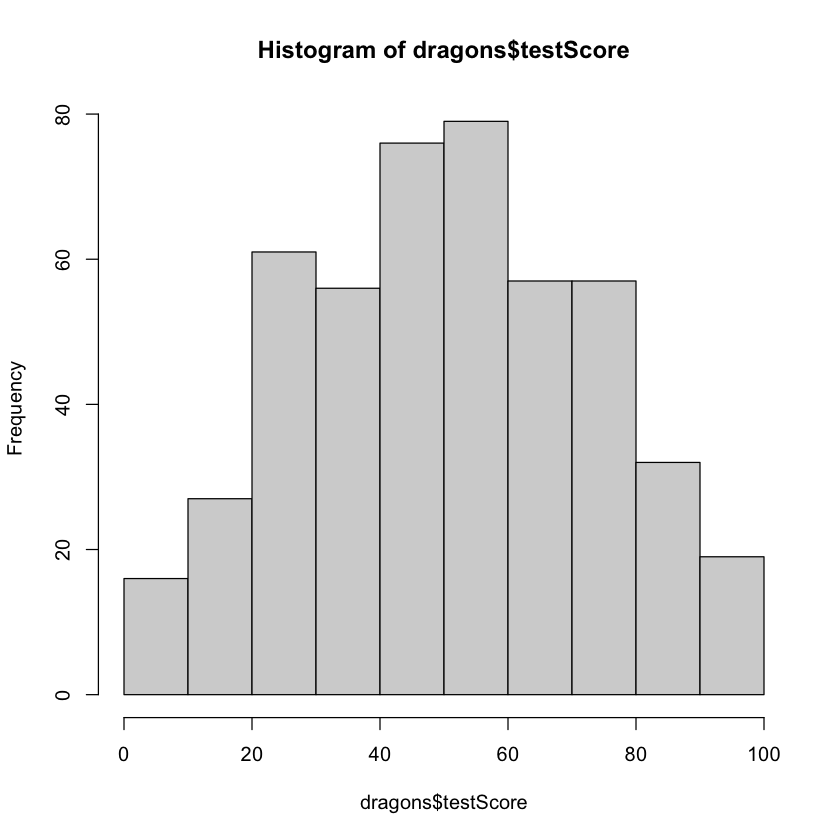

In [2]:
hist(dragons$testScore)  # seems close to a normal distribution - good!

It is good practice to **standardise** your explanatory variables before proceeding, so that they have a mean of zero and standard deviation of one. It ensures that the estimated coefficients are all on the same scale, making it easier to compare effect sizes (and it improves model convergence). You can use `scale()` to do that:

In [3]:
dragons$bodyLength2 <- scale(dragons$bodyLength)

`scale()` centers the data (the column mean is subtracted from the values in the column) and then scales it (the centered column values are divided by the column’s standard deviation).

Back to our question: is the test score affected by body length?

## Fit all data in one analysis

One way to analyse this data would be to try fitting a linear model to all our data, ignoring the sites and the mountain ranges for now.

We are going to work in `lme4`, so load the package (or use `install.packages()` if you don’t have `lme4` on your computer):


In [4]:
library(lme4)

Loading required package: Matrix



Fit the model with `testScore` as the response and `bodyLength2` as the predictor and have a look at the output:

In [5]:
basic.lm <- lm(testScore ~ bodyLength2, data = dragons)
summary(basic.lm)


Call:
lm(formula = testScore ~ bodyLength2, data = dragons)

Residuals:
   Min     1Q Median     3Q    Max 
-56.96 -16.41  -0.78  15.19  55.20 

Coefficients:
            Estimate Std. Error t value            Pr(>|t|)    
(Intercept)   50.386      0.968   52.07 <0.0000000000000002 ***
bodyLength2    8.996      0.969    9.29 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.2 on 478 degrees of freedom
Multiple R-squared:  0.153,	Adjusted R-squared:  0.151 
F-statistic: 86.2 on 1 and 478 DF,  p-value: <0.0000000000000002


Let’s plot the data with ggplot2:

`geom_smooth()` using formula 'y ~ x'



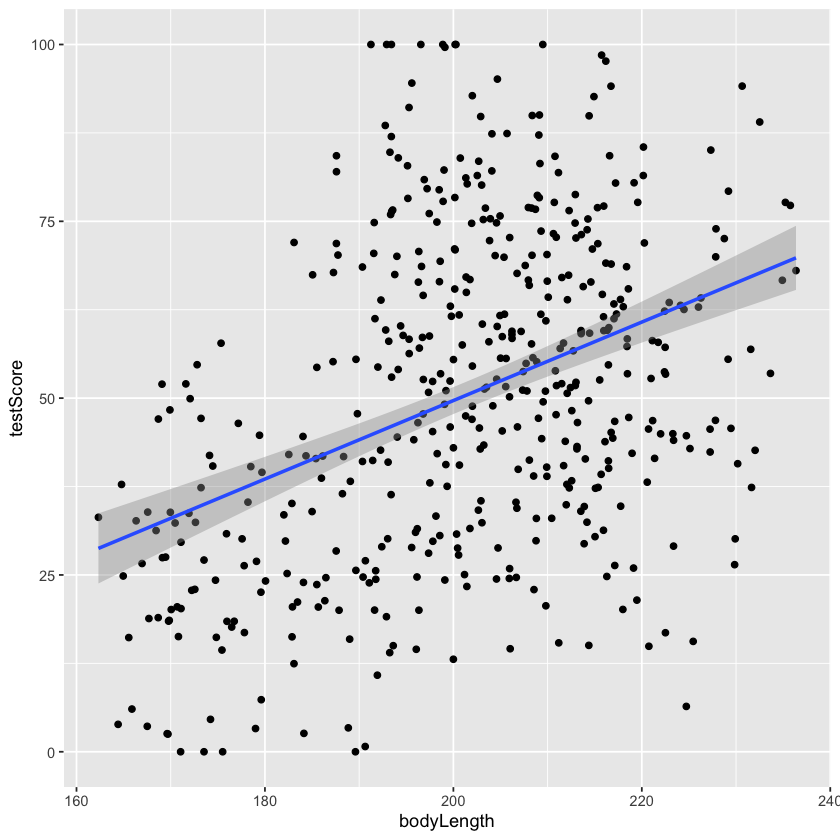

In [6]:
library(ggplot2)

ggplot(dragons, aes(x = bodyLength, y = testScore)) + geom_point() + geom_smooth(method = "lm")

Ok, so both from the linear model and from the plot it seems like bigger dragons do better in our intelligence test. That seems a bit odd, size shouldn’t really affect the test scores.

But… Are the assumptions met?

Plot the residuals - the red line should be close to being flat, like the dashed grey line:

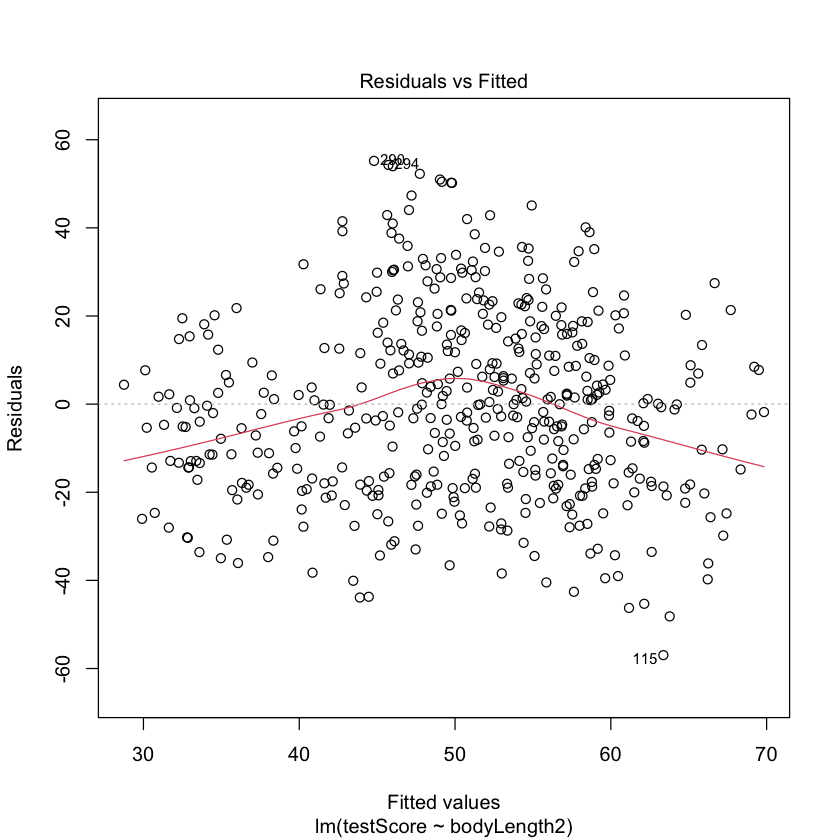

In [7]:
plot(basic.lm, which = 1)

Not perfect... but since this is a fictional example we will go with it! For your own data be careful: the bigger the sample size, the less of a trend you'd expect to see.

Have a quick look at the qqplot too - points should ideally fall onto the diagonal dashed line:

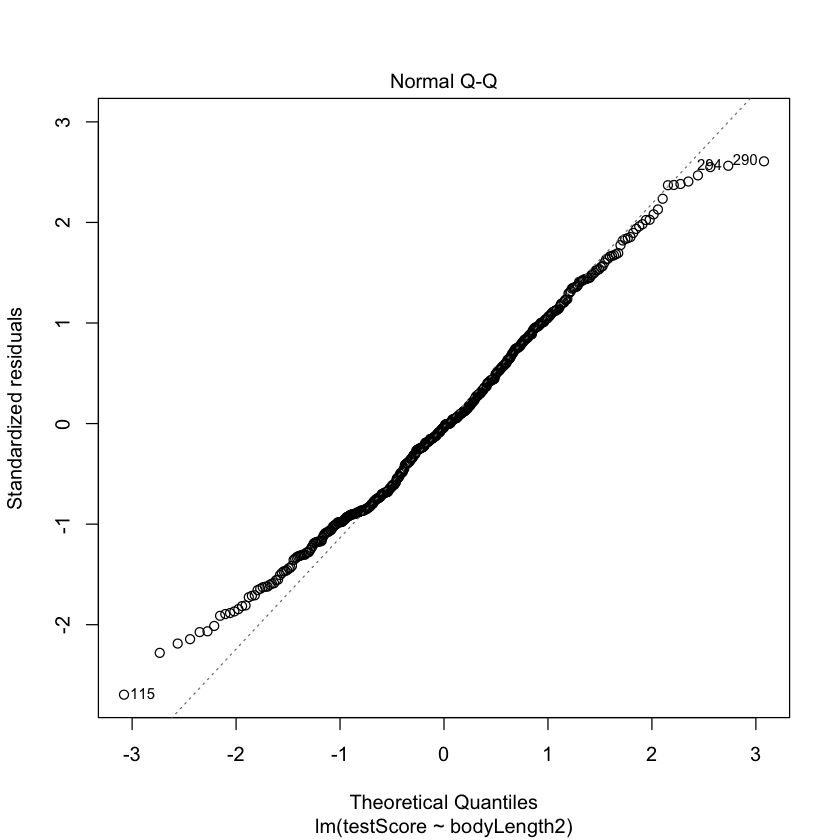

In [8]:
plot(basic.lm, which = 2)

A bit off at the extremes, but that's often the case; again doesn't look too bad.

However, what about observation independence? Are our data independent?

We collected multiple samples from eight mountain ranges. It’s perfectly plausible that the data from within each mountain range are more similar to each other than the data from different mountain ranges - they are correlated.

Have a look at the data to see if above is true:

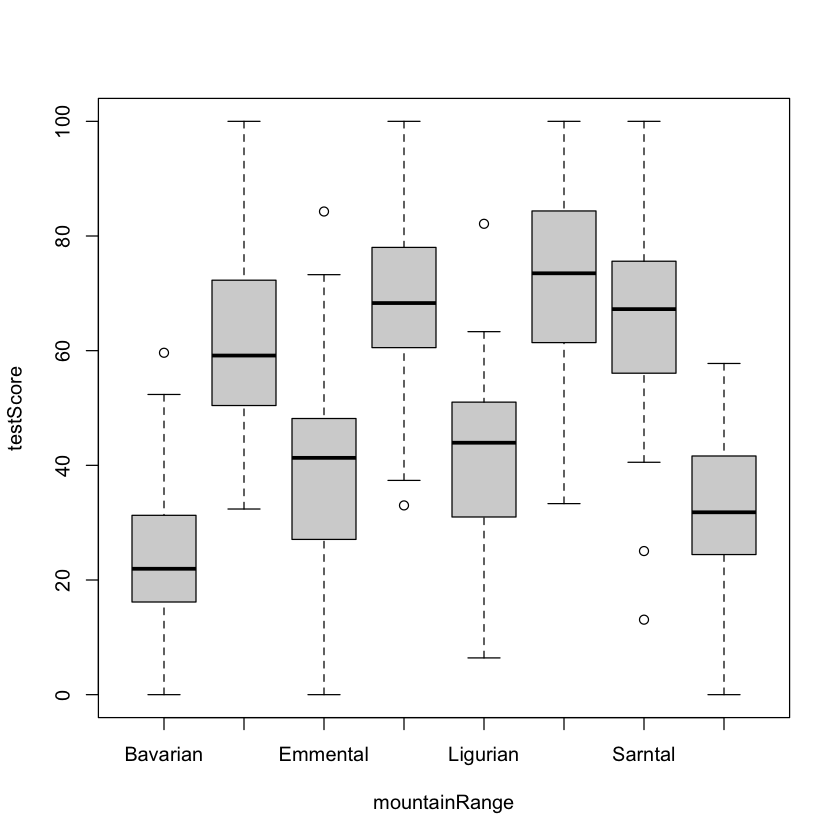

In [9]:
boxplot(testScore ~ mountainRange, data = dragons)

Certainly looks like something is going on here!

We could also plot it colouring points by mountain range:

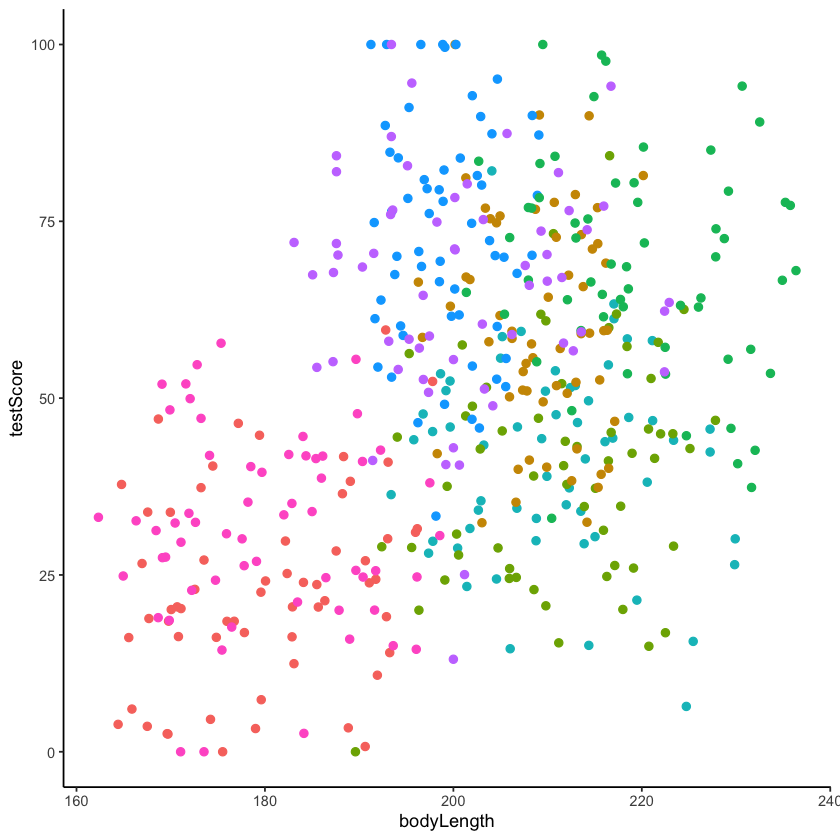

In [10]:
ggplot(dragons, aes(x = bodyLength, y = testScore, colour = mountainRange)) + geom_point(size = 2) + theme_classic() + theme(legend.position = "none")


From the above plots it looks like our mountain ranges vary both in the dragon body length and in their test scores. This confirms that our observations from within each of the ranges **aren’t independent**. We can’t ignore that.

So what do we do?

## Run multiple analyses

We could run many separate analyses and fit a regression for each of the mountain ranges.

Lets have a quick look at the data split by mountain range. We use the `facet_wrap` to do that:

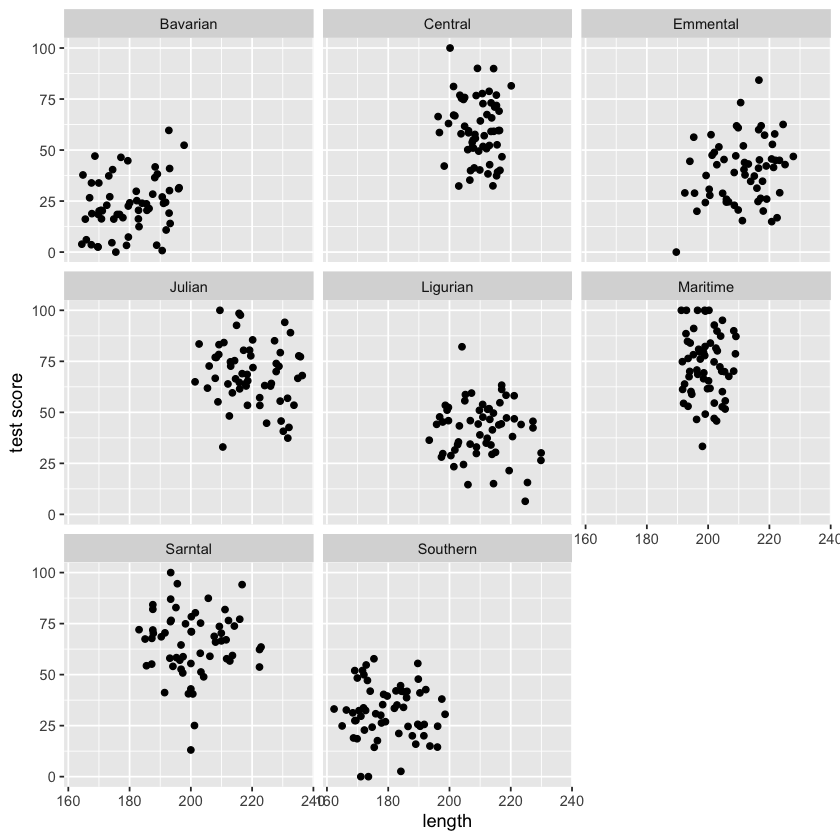

In [11]:
ggplot(aes(bodyLength, testScore), data = dragons) + geom_point() + facet_wrap(~ mountainRange) + xlab("length") + ylab("test score")

That’s eight analyses. Oh wait, we also have different sites, which similarly to mountain ranges aren’t independent… So we could run an analysis for each site in each range separately.

To do the above we would have to estimate a slope and intercept parameter for each regression. That’s two parameters, three sites and eight mountain ranges, which means **48 parameter estimates** (2 x 3 x 8 = 48)! Moreover, the sample size for each analysis would be only 20.

This presents problems - not only we are **hugely decreasing our sample size**, but we are also **increasing the error due through carrying out multiple comparisons**. Not ideal!

## Modify the current model

We want to use all the data, but account for the data coming from different mountain ranges (let’s put sites on hold for a second to make things simpler).

Add mountain range as a fixed effect to our `basic.lm`:

In [12]:
mountain.lm <- lm(testScore ~ bodyLength2 + mountainRange, data = dragons)
summary(mountain.lm)


Call:
lm(formula = testScore ~ bodyLength2 + mountainRange, data = dragons)

Residuals:
   Min     1Q Median     3Q    Max 
-52.26  -9.93   0.36   9.99  44.49 

Coefficients:
                      Estimate Std. Error t value             Pr(>|t|)    
(Intercept)             23.382      2.579    9.07 < 0.0000000000000002 ***
bodyLength2              0.205      1.293    0.16               0.8738    
mountainRangeCentral    36.583      3.599   10.16 < 0.0000000000000002 ***
mountainRangeEmmental   16.209      3.697    4.38            0.0000143 ***
mountainRangeJulian     45.115      4.190   10.77 < 0.0000000000000002 ***
mountainRangeLigurian   17.748      3.674    4.83            0.0000018 ***
mountainRangeMaritime   49.881      3.139   15.89 < 0.0000000000000002 ***
mountainRangeSarntal    41.978      3.197   13.13 < 0.0000000000000002 ***
mountainRangeSouthern    8.520      2.731    3.12               0.0019 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residu

Now body length is not significant. But let’s think about what we are doing here for a second. The above model is estimating the difference in test scores between the mountain ranges - we can see all of them in the model output returned by `summary()`. But we are not interested in that, we just want to know whether body length affects test scores and we want to simply **control for the variation** coming from mountain ranges.

This is what we refer to as **"random factors"** and so we arrive at mixed effects models. Ta-daa!

## Mixed effects models

Mixed model is a good choice here: it will allow us to **use all the data we have** (higher sample size) and yet **account for the correlations between data** coming from the sites and mountain ranges. We will also **estimate fewer parameters** and **avoid problems with multiple comparisons** that we would encounter while using separate regressions.

### Fixed and random effects

Let’s talk a little about the **fixed and random effects** first - the literature isn’t clear on the exact definitions of those, so I’m going to give you a somehow “introductory” explanation. See links in the further reading below if you want to know more.

In some cases the same variable could be considered either a random or a fixed effect (and sometimes even both at the same time!), so you have to think not only about your data, but also **about the questions you are asking** and construct your models accordingly.

In broad terms, with **fixed effects** we are interested in evaluating the levels of our variable and using data from all its levels. In our case here, we are interested in making conclusions about how dragon body length impacts the dragon’s test score. So body length is a fixed effect.

On the other hand, **random effects** (or random factors - as they will be **categorical**, you can’t force R to treat a continuous variable as a random effect) are usually **grouping factors** for which we are trying to control. A lot of the time we are not specifically interested in their impact on the response variable. Additionally, the data for our random effect is just **a sample of all the possibilities**. Keep in mind that random doesn’t have much to do with mathematical randomness. Yes, it’s confusing. Just think about them as the grouping variables for now.

Strictly speaking it’s all about making our models better - **and getting better estimates**.

In this particular case, we are looking to control for the effects of the mountain range. We haven’t sampled all the mountain ranges in the world (we have eight), so our data are just a random sample of all the existing mountain ranges. We are not really interested in the effect of each specific mountain range on the test score - but we know that the test scores from within the ranges might be correlated, so we want to control for that.

If we specifically chose eight particular mountain ranges a priori and we were interested in those ranges and wanted to make predictions about them then mountain range would be fitted as a fixed effect.

**NOTE:** Generally you want your random effect to have **more than five levels**. So, for instance, if we wanted to control for the effects of dragon’s sex on intelligence, we would fit sex (a two level factor: male or female) **as a fixed, not random, effect**.

**So the big question is:** what are you trying to do? What are you trying to make predictions about? What is just variation (a.k.a “noise”) that you need to control for?

Further reading for the keen:

- [Is it a fixed or random effect?](https://dynamicecology.wordpress.com/2015/11/04/is-it-a-fixed-or-random-effect/)
- A useful way to think about fixed vs. random effects is in terms of partitioning the variation and estimating random effects with **partial pooling**. The description [here](http://stats.stackexchange.com/questions/4700/what-is-the-difference-between-fixed-effect-random-effect-and-mixed-effect-mode) is the most accessible one I could find for now and you can find more opinions in the comments of under the previous link too (search for pooling and shrinkage too if you are very keen).
- [How many terms? On model complexity](https://dynamicecology.wordpress.com/2015/02/05/how-many-terms-in-your-model-before-statistical-machismo/)
- [More on model complexity](https://dynamicecology.wordpress.com/2014/12/02/why-are-your-statistical-models-more-complex-these-days/)

Have a look at some of the fixed and random effects definitions gathered by Gelman in [this paper](http://www.stat.columbia.edu/~gelman/research/published/AOS259.pdf).


### Let’s fit our first mixed model

Alright! Still with me? We have a response variable, the test score, and we are attempting to **explain part of the variation** in score through fitting body length as a fixed effect. But the response variable has some **residual variation** (i.e. unexplained variation) associated with mountain ranges. By using random effects we are modeling that unexplained variation through **variance**.

\[Sidenote: If you are confused between variation and variance: **variation** is a generic word, similar to dispersion or variability; **variance** is a particular measure of variation, it quantifies the dispersion if you wish\]

Note that **our question changes slightly** here: while we still want to know whether there is an association between dragon’s body length and the test score, we want to know if that association exists **after** controlling for the variation in mountain ranges.

We will fit the random effect using `(1|variableName)`:



In [13]:
mixed.lmer <- lmer(testScore ~ bodyLength2 + (1|mountainRange), data = dragons)
summary(mixed.lmer)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange)
   Data: dragons

REML criterion at convergence: 3986

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.482 -0.651  0.007  0.669  2.958 

Random effects:
 Groups        Name        Variance Std.Dev.
 mountainRange (Intercept) 340      18.4    
 Residual                  224      15.0    
Number of obs: 480, groups:  mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.552    7.69
bodyLength2    0.538      1.275    0.42

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

Once we accounted for the mountain ranges, it’s obvious that dragon body length doesn’t actually explain the differences in the test scores.

Keep in mind that the random effect of the mountain range is **meant to capture all the influences of mountain ranges on dragon test scores** - whether we observed those influences explicitly or not, whether those influences are big or small etc. It could be many, many teeny-tiny influences that, when combined, affect the test scores and that’s what we are hoping to control for.

As always, it’s good practice to have a look at the plots to check our assumptions:

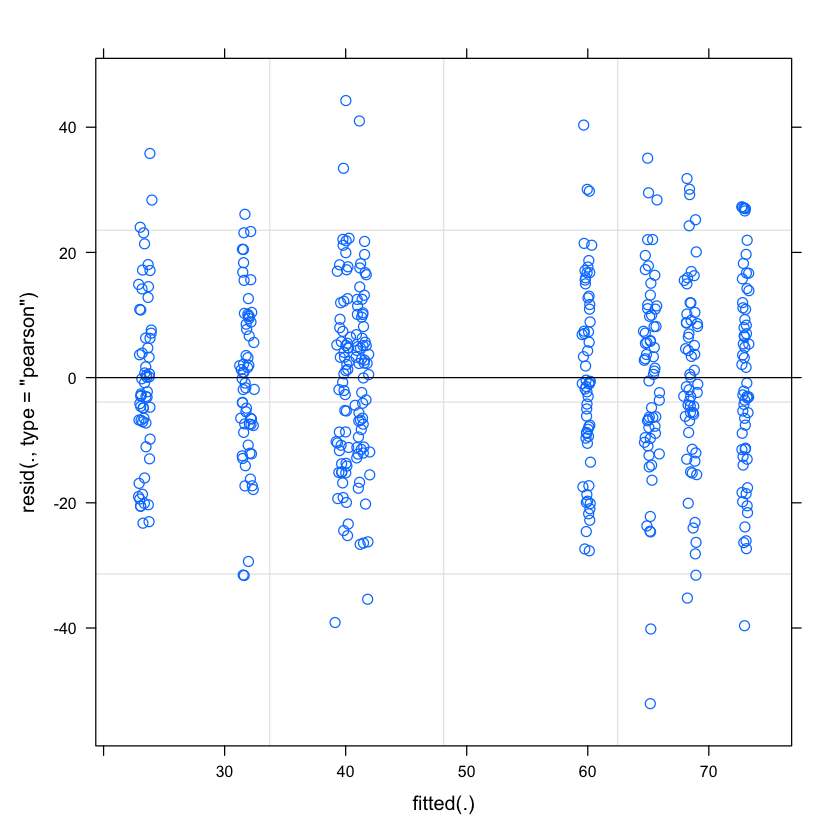

In [14]:
plot(mixed.lmer)  

Looks alright, no patterns evident!

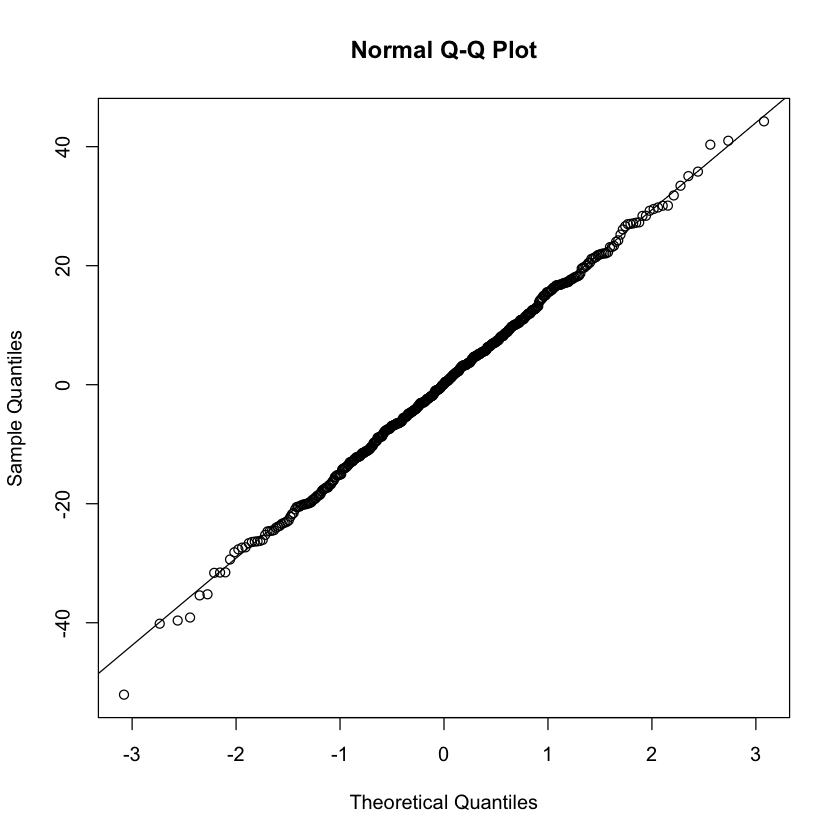

In [15]:
qqnorm(resid(mixed.lmer))
qqline(resid(mixed.lmer))

Points fall nicely onto the line - good!

Let’s go back to the summary and look at our results again:

In [16]:
summary(mixed.lmer)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange)
   Data: dragons

REML criterion at convergence: 3986

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.482 -0.651  0.007  0.669  2.958 

Random effects:
 Groups        Name        Variance Std.Dev.
 mountainRange (Intercept) 340      18.4    
 Residual                  224      15.0    
Number of obs: 480, groups:  mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.552    7.69
bodyLength2    0.538      1.275    0.42

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

We can see the variance for the `mountainRange = 340`. Mountain ranges are clearly important - they explain a lot of variation. How do we know that? We can take the variance for the `mountainRange` and divide it by the total variance:

In [17]:
340/(340 + 224)

[1] 0.6028

So the differences between mountain ranges explain ~60% of the variance. Do keep in mind that’s 60% of variance “left over” after the variance explained by our fixed effects.

### Types of random effects

Before we go any further let’s review the syntax above and chat about crossed and nested random effects. It’s useful to get those clear in your head.

**Reminder:** a factor is just any categorical independent variable.

Above we used `(1|mountainRange)` to fit our random effect - whatever is on the right side of `|` operator is a factor and referred to as a “grouping factor” for the term

**Random effects (factors) can be crossed or nested** - it depends on the relationship between the variables. Let’s have a look.

#### Crossed random effects

Be careful with the nomenclature. There are **"hierarchical linear models"** (HLMs) or **"multilevel models"** out there, but while all HLMs are mixed models, **not all mixed models are hierarchical**. That’s because you can have **crossed (or partially crossed) random factors** that do not represent levels in a hierarchy.

Think for instance about our study where you monitor dragons (subject) across different mountain ranges (context) and imagine that we collect **multiple observations per dragon** (we give it the test multiple times - risking **pseudoreplication**). Since our dragons can fly it’s easy to imagine that **we might observe the same dragon across different mountain ranges**, but also that we might not see all the dragons visiting all of the mountain ranges. Therefore, we can potentially observe every dragon in every mountain range (**crossed**) or at least observe some dragons across some of the mountain ranges (**partially crossed**). We would then fit the identity of the dragon and mountain range as (partially) crossed random effects.

#### Nested random effects

If this sounds confusing, not to worry - `lme4` handles partially and fully crossed factors well, they don’t have to be hierarchical or "multilevel" by design. However, **the same model specification can be used to represent both (partially) crossed or nested factors**, so you can’t use the models specification to tell you what’s going on with the random factors, you have to look at the structure of the factors in the data. To make things easier for yourself code your data properly and **avoid implicit nesting**. Not sure what implicit nesting is? Read on.

#### Implicit vs. explicit nesting

To tackle this, let’s look at another aspect of our study: we collected the data on dragons not only across multiple mountain ranges, but also across several sites within those mountain ranges. If you don’t remember have another look at the data:

In [18]:
head(dragons)
str(dragons)

,testScore,bodyLength,mountainRange,site,bodyLength2
,<dbl>,<dbl>,<fct>,<fct>,"<dbl[,1]>"
1,16.147,165.5,Bavarian,a,-2.206
2,33.886,167.6,Bavarian,a,-2.082
3,6.038,165.9,Bavarian,a,-2.186
4,18.839,167.7,Bavarian,a,-2.074
5,33.862,170.0,Bavarian,a,-1.934
6,47.043,168.7,Bavarian,a,-2.013


'data.frame':	480 obs. of  5 variables:
 $ testScore    : num  16.15 33.89 6.04 18.84 33.86 ...
 $ bodyLength   : num  166 168 166 168 170 ...
 $ mountainRange: Factor w/ 8 levels "Bavarian","Central",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ site         : Factor w/ 3 levels "a","b","c": 1 1 1 1 1 1 1 1 1 1 ...
 $ bodyLength2  : num [1:480, 1] -2.21 -2.08 -2.19 -2.07 -1.93 ...
  ..- attr(*, "scaled:center")= num 201
  ..- attr(*, "scaled:scale")= num 16.2


Just like we did with the mountain ranges, we have to assume that data collected within our sites might be **correlated** and so we should include sites as **an additional random effect** in our model.

Our site variable is a three-level factor, with sites called a, b and c. The nesting of the site within the mountain range is **implicit** - our sites are meaningless without being assigned to specific mountain ranges, i.e. there is nothing linking site b of the Bavarian mountain range with site b of the Central mountain range. To avoid future confusion we should create a new variable that is **explicitly nested**. Let’s call it sample:

In [19]:
dragons <- within(dragons, sample <- factor(mountainRange:site))

head(dragons)

,testScore,bodyLength,mountainRange,site,bodyLength2,sample
,<dbl>,<dbl>,<fct>,<fct>,"<dbl[,1]>",<fct>
1,16.147,165.5,Bavarian,a,-2.206,Bavarian:a
2,33.886,167.6,Bavarian,a,-2.082,Bavarian:a
3,6.038,165.9,Bavarian,a,-2.186,Bavarian:a
4,18.839,167.7,Bavarian,a,-2.074,Bavarian:a
5,33.862,170.0,Bavarian,a,-1.934,Bavarian:a
6,47.043,168.7,Bavarian,a,-2.013,Bavarian:a


Now it’s obvious that we have 24 samples (8 mountain ranges x 3 sites) and not just 3 - our `sample` is a 24-level factor and we should use that instead of using `site` in our models: each site belongs to a specific mountain range.

**To sum up**: for **nested random effects** the factor appears **ONLY** within a particular level of another factor (each site belongs to a specific mountain range and only to that range); for **crossed effects** a given factor appears in more than one level of another factor (dragons appearing within more than one mountain range). **Or you can just remember that if your random effects aren’t nested then they are crossed!**

### Our second mixed model

Based on the above, using following specification would be **wrong**:

In [20]:
mixed.WRONG <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|site), data = dragons)  # treats the two random effects as if they are crossed

But we can go ahead and fit a new model, one that takes into account both the differences between the mountain ranges as well as the differences between the sites within those mountain ranges, by using our `sample` variable.

Our question gets **adjusted slightly again**: Is there an association between body length and intelligence in dragons **after** controlling for variation in mountain ranges and sites within mountain ranges?

In [21]:
mixed.lmer2 <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|sample), data = dragons)  # the syntax stays the same, but now the nesting is taken into account
summary(mixed.lmer2)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange) + (1 | sample)
   Data: dragons

REML criterion at convergence: 3970

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.243 -0.675 -0.012  0.697  2.881 

Random effects:
 Groups        Name        Variance Std.Dev.
 sample        (Intercept)  23.1     4.81   
 mountainRange (Intercept) 327.6    18.10   
 Residual                  208.6    14.44   
Number of obs: 480, groups:  sample, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.507    7.74
bodyLength2    0.831      1.681    0.49

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

Here, we are trying to account for **all the mountain-range-level** and **all the site-level influences** and we are hoping that our random effects have soaked up all these influences, so we can control for them in the model.

For the record you could also use the below syntax, but I’d advise you to set out your variables properly and make sure nesting is stated explicitly within them - that way you don’t have to remember to specify the nesting.

`(1|mountainRange/site)` or even `(1|mountainRange) + (1|mountainRange:site)`

In [22]:
mixed.lmer2 <- lmer(testScore ~ bodyLength2 + (1|mountainRange/site), data = dragons)  # the syntax stays the same, but now the nesting is taken into account
summary(mixed.lmer2)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange/site)
   Data: dragons

REML criterion at convergence: 3970

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.243 -0.675 -0.012  0.697  2.881 

Random effects:
 Groups             Name        Variance Std.Dev.
 site:mountainRange (Intercept)  23.1     4.81   
 mountainRange      (Intercept) 327.6    18.10   
 Residual                       208.6    14.44   
Number of obs: 480, groups:  site:mountainRange, 24; mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)   50.386      6.507    7.74
bodyLength2    0.831      1.681    0.49

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

Let’s plot this again - visualising what’s going on is always helpful. You should be able to see eight mountain ranges with three sites (different colour points) within them, with a line fitted through each site:

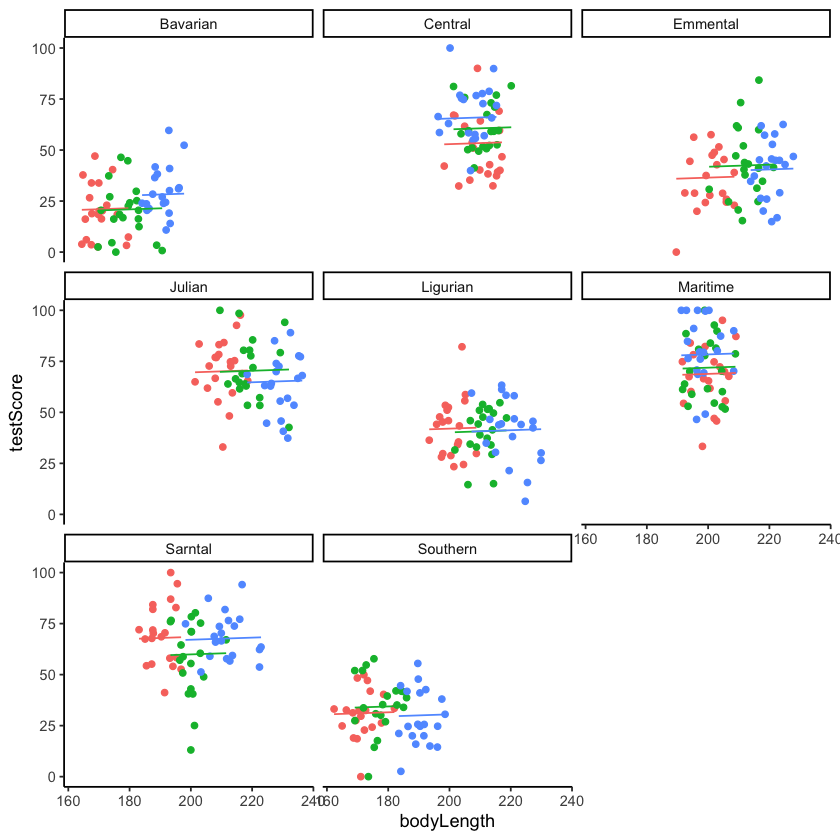

In [23]:
ggplot(dragons, aes(x = bodyLength, y = testScore, colour = site)) +
  facet_wrap(~mountainRange, nrow=3) +
  geom_point() +
  theme_classic() +
  geom_line(data = cbind(dragons, pred = predict(mixed.lmer2)), aes(y = pred)) +
  theme(legend.position = "none")

**Well done for getting here!** You have now fitted mixed models and you know how to account for crossed random effects too. You saw that failing to account for the correlation in data might lead to misleading results - it seemed that body length affected the test score until we accounted for the variation coming from mountain ranges. We can see now that body length doesn’t influence the test scores - great! We can pick smaller dragons for any future training, smaller ones should be more manageable! ;)

If you are particularly keen the next section gives you a few options when it comes to **presenting your model results**, and in the last "extra" section you can learn about the **model selection conundrum**. There is just a little bit more code there to get through if you fancy those.

### Presenting your model results

Once you get your model you have to **present** it in a nicer form.

#### Tables

For `lme4` if you are looking for a table, I’d recommend that you have a look at the `stargazer` package.



In [24]:
library(stargazer)


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




Stargazer is very nicely annotated and there are lots of resources (e.g. [this](https://cran.r-project.org/web/packages/stargazer/vignettes/stargazer.pdf)) out there and a great [cheat sheet](http://jakeruss.com/cheatsheets/stargazer.html), so I won’t go into too much detail, as I’m confident you will find everything you need.

Here is a quick example - simply plug in your model name, in this case `mixed.lmer2` into the `stargazer` function. I set `type` to `"text"` so that you can see the table in your console - I usually tweak the table like this till I’m happy with it and then export it using type = `"latex"`, but `"html"` might be more useful for you if you are not a LaTeX user.

If you are keen, explore this table a little further - what would you change? What would you get rid off?

In [25]:
stargazer(mixed.lmer2, type = "text",
          digits = 3,
          star.cutoffs = c(0.05, 0.01, 0.001),
          digit.separator = "")


                         Dependent variable:     
                    -----------------------------
                              testScore          
-------------------------------------------------
bodyLength2                     0.831            
                               (1.681)           
                                                 
Constant                      50.390***          
                               (6.507)           
                                                 
-------------------------------------------------
Observations                     480             
Log Likelihood                -1985.000          
Akaike Inf. Crit.             3980.000           
Bayesian Inf. Crit.           4001.000           
Note:               *p<0.05; **p<0.01; ***p<0.001


#### Dot-and-Whisker plots

If you are looking for **a way to create plots of your results** check out dotwhisker and this [tutorial](https://cran.r-project.org/web/packages/dotwhisker/vignettes/dotwhisker-vignette.html).

#### Further processing

If you’d like to be able **to do more with your model results**, for instance process them further, collate model results from multiple models or plot them have a look at the `broom` package: this [tutorial](http://varianceexplained.org/r/broom-intro/) is a great start.

### EXTRA: P-values and model selection

Please be **very, very careful** when it comes to model selection. Focus on your **question**, don’t just plug into and drop variables from a model haphazardly till you make something “significant”. I choose variables based on biology/ecology, I might use the model selection to check a couple of non-focal parameters, but I keep the “core” of the model untouched in most cases. **Define your goals and questions and focus on that**. Also, don’t just put all possible variables in (i.e. don’t **overfit**) - remember that as a rule of thumb **you need 10 times more data than parameters** you are trying to estimate.

For more info on overfitting check out this [tutorial](https://ourcodingclub.github.io/2017/02/28/modelling.html).

#### Fixed effects structure

**Before we start, again: think twice before trusting model selection!**

Most of you are probably going to be predominantly interested in your fixed effects, so let’s start here. `lme4` doesn’t spit out p-values for the parameters by default - this is a conscious choice made by the authors of the package, as there are many problems with p-values (I’m sure you are aware of the debates!)

You will inevitably look for a way to assess your model though, so here are a few solutions on how to go about hypothesis testing in linear mixed models (LMMs):

From worst to best:

- Wald Z-tests
- Wald t-tests (but LMMs need to be balanced and nested)
- Likelihood ratio tests (via `anova()` or `drop1()`)
- `MCMC` or parametric bootstrap confidence intervals

(See [this link](http://stats.stackexchange.com/questions/95054/how-to-get-an-overall-p-value-and-effect-size-for-a-categorical-factor-in-a-mi) for more information and further reading)

I think that `MCMC` and bootstrapping are a bit out of our reach for this workshop, so let’s have a quick go at **likelihood ratio tests** using `anova()`. With large sample sizes p-values based on the likelihood ratio are generally considered ok. **NOTE:** With small sample sizes you might want to look into deriving p-values using the Kenward-Roger or Satterthwaite approximations (for `REML` models). Check out the `pbkrtest` package.

Fit the models, a full model and a reduced model in which we dropped our fixed effect (`bodyLength2`):




In [26]:
full.lmer <- lmer(testScore ~ bodyLength2 + (1|mountainRange) + (1|sample), data = dragons, REML = FALSE)
reduced.lmer <- lmer(testScore ~ 1 + (1|mountainRange) + (1|sample), data = dragons, REML = FALSE)


Compare them:

In [27]:
anova(reduced.lmer, full.lmer)  # the two models are not significantly different!

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
reduced.lmer,4,3987,4004,-1990,3979,NA,NA,NA
full.lmer,5,3989,4010,-1989,3979,0.2868,1,0.5923


**REML** stands for **restricted (or "residual") maximum likelihood** and it is the default parameter estimation criterion for linear mixed models. As you probably guessed, **ML** stands for **maximum likelihood** - you can set `REML = FALSE` in your call to `lmer` to use ML estimates. However, **ML estimates are known to be bias** and with REML being usually less bias, **REML estimates of variance components are generally preferred**. This is why in our previous models we skipped setting `REML` - we just left it as default (i.e. `REML = TRUE`).

**REML** assumes that fixed effects structure is correct. You should **use maximum likelihood when comparing models with different fixed effects**, as **ML** doesn’t rely on the coefficients of the fixed effects - and that’s why we are refitting our full and reduced models above with the addition of `REML = FALSE` in the call.

Even though you **use ML to compare models** you should **report parameter estimates from your final "best" REML model**, as **ML** may underestimate variance of the random effects.

**NOTE 2:** Models can also be compared using the `AICc` function from the `AICcmodavg` package. The Akaike Information Criterion (AIC) is a measure of model quality. AICc corrects for bias created by small sample size when estimating AIC. Generally, if models are within 2 AICc units of each other they are very similar. Within 5 units they are quite similar, over 10 units difference and you can probably be happy with the model with lower AICc. As with p-values though, there is no “hard line” that’s always correct.

**NOTE 3:** There isn’t really an agreed upon way of dealing with the variance from the random effects in mixed models when it comes to assessing significance. So both, **p-values** and **effect sizes** have issues, although from what I gather p-values seem to cause more disagreement than effect sizes, at least in the R community.

#### Random effects structures

Now you might wonder about selecting your random effects. In general, I’d advise you to think about your **experimental design, your system and data collected as well as your questions**.

If your random effects are there to deal with **pseudoreplication** then it doesn’t really matter whether they are "significant" or not - they **are part of your design** and have to be included. Imagine we tested our dragons multiple times - we then have to fit dragon identity as a random effect.

On the other hand if you are trying to account for other variability that you think might be important it becomes a bit harder. Imagine we measured the mass of our dragons over their lifespans (let’s say 100 years). We might then want to fit year as a random effect to account for any temporal variation - maybe some years were affected by drought, the resources were scarce and so dragon mass was negatively impacted. Year would definitely be a sensible random effect, although strictly speaking not a must.

When it comes to such random effects you can use **model selection** to help you decide what to keep in. Following Zuur’s advice we **use `REML` estimators for comparison of models with different random effects** (we keep fixed effects constant). (Zuur: “Two models with nested random structures cannot be done with ML because the estimators for the variance terms are biased.” )

**NOTE:** Do **NOT** vary random and fixed effects at the same time - either deal with your random effects structure or with your fixed effects structure at any given point.

**NOTE 2:** Do **NOT** compare `lmer` models with `lm` models (or `glmer` with `glm`).

#### The entire model selection

A few notes on the process of model selection. There are two ways here: (i) **"top-down"**, where you start with a complex model and gradually reduce it, and (ii) **"step up"**, where you start with a simple model and add new variables to it. Unfortunately, you might arrive at different final models by using those strategies and so you need to be careful.

The model selection process recommended by Zuur is a top-down strategy and goes a follows:

1. fit a **full model** (he even recommends “beyond optimal” i.e. more complex than you’d expect or want it to be)
2. sort out the **random effects structure** (use `REML` likelihoods or `REML` AIC or BIC)
3. sort out **fixed effects structure** (either use `REML` the F-statistic or the t-statistic or compare nested `ML` models - keep your random effects constant)
4. once you arrive at the **final model present it using `REML` estimation**

**NOTE:** At the risk of sounding like a broken record: I think it’s best to decide on what your model is based on biology/ecology/data structure etc. than through following model selection blindly. Additionally, just because something is non-significant doesn’t necessarily mean you should always get rid of it.





## THE END

**Well done for getting through this!** As you probably gather mixed effects models can be a bit tricky and often there isn’t much consensus on the best way to tackle something within them. The coding bit is actually the (relatively) easy part here. Be mindful of what you are doing, prepare the data well and things should be alright.

I haven’t gone into details of intercepts vs. slopes or interactions, which you might well need to deal with your data and questions properly. If people find this useful I will consider setting some time aside for Part 2.

I hope that you found the tutorial useful - please let me know if you have any questions.